### 基于LightGBM的LambdaMART排序模型
基本思想：为每个预测时间步都训练一个模型，输入为前段时间的信息，输出为预测时间步的排序信息

训练集和测试集应以时间段来划分

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
# from utils import *
import lightgbm as lgb

random.seed(42)

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.metrics import classification_report, mean_squared_error, precision_score


def cal_ndcg(n, true, pred):
    """
    calculate the NDCG@n score

    :param n: top n elements to be considered
    :param true: ground truth
    :param pred: predicted values
    :return: ndcg score
    """

    _true = true.reshape(-1)
    _pred = pred.reshape(-1)

    _list = list(zip(_true, _pred))
    true_list = sorted(_list, key=lambda x: x[0], reverse=True)[:n]
    pred_list = sorted(_list, key=lambda x: x[1], reverse=True)[:n]

    true_array = np.zeros((len(true_list), 2))
    pred_array = np.zeros((len(pred_list), 2))

    for i, num in enumerate(true_list):
        true_array[i] = np.array([i + 1, num[0]])

    for i, num in enumerate(pred_list):
        pred_array[i] = np.array([i + 1, num[0]])

    # 使用工业界的算法
        ideal_score = np.sum((2 ** true_array[:, 1] - 1) / np.log2(true_array[:, 0] + 1))
        pred_score = np.sum((2 ** pred_array[:, 1] - 1) / np.log2(pred_array[:, 0] + 1))

    # 使用普通的算法
    # ideal_score = np.sum((true_array[:, 1]) / np.log2(true_array[:, 0] + 1))
    # pred_score = np.sum((pred_array[:, 1]) / np.log2(pred_array[:, 0] + 1))

    return pred_score / ideal_score


def eval_model(method, y_true_1, y_pred_1, scaler):
    """
    Model evaluation (after transforming to the original scale)

    :param method: evaluate method
    :param y_true_1: ground truth
    :param y_pred_1: predicted values
    :param scaler: the scaler used in data pre-processing
    :return:
    """
    if scaler is not None:
        # y_true = scaler.inverse_transform(y_true_1.reshape(-1, 1)).reshape(y_true_1.shape)
        # y_pred = scaler.inverse_transform(y_pred_1.reshape(-1, 1)).reshape(y_pred_1.shape)
        y_true = scaler.inverse_transform(y_true_1)
        y_pred = scaler.inverse_transform(y_pred_1)
    else:
        y_true = y_true_1.copy()
        y_pred = y_pred_1.copy()

    if method.lower() == 'mae':
        errors = np.abs(y_true - y_pred)
        annual_mae = np.mean(errors, axis=0)
        overall_mae = np.mean(errors, axis=None)

        return overall_mae, annual_mae

    if method.lower() == 'mse':
        errors = np.square(y_true - y_pred)
        annual_mse = np.mean(errors, axis=0)
        overall_mse = np.mean(errors, axis=None)

        return overall_mse, annual_mse

    if method.lower() == 'rmse':
        errors = np.square(y_true - y_pred)
        annual_rmse = np.sqrt(np.mean(errors, axis=0))
        overall_rmse = np.sqrt(np.mean(errors, axis=None))

        return overall_rmse, annual_rmse

    if method.lower() == 'mape':
        errors = np.abs((y_true - y_pred) / y_true)
        annual_mape = np.mean(errors, axis=0)
        overall_mape = np.mean(errors, axis=None)

        return overall_mape, annual_mape

    if method.lower() == 'ndcg':
        n = 20
        samples, years = y_true.shape
        annual_ndcg = []

        for year in range(years):
            annual_ndcg.append(cal_ndcg(n, y_true[:, year], y_pred[:, year]))

        overall_ndcg = cal_ndcg(n, np.sum(y_true, axis=1), np.sum(y_pred, axis=1))

        return overall_ndcg, annual_ndcg

    if method.lower() == 'classification':
        percentiles = [70, 85, 95]
        ps_true = np.percentile(y_true, percentiles, axis=0)
        ps_pred = np.percentile(y_pred, percentiles, axis=0)

        _y_true = y_true.copy()
        _y_pred = y_pred.copy()

        for i in range(_y_true.shape[0]):
            for j in range(_y_true.shape[1]):
                true_es = _y_true[i][j]
                pred_es = _y_pred[i][j]

                if np.isclose(true_es, 0.0):
                    _y_true[i][j] = 0
                elif 0 < true_es < ps_true[0][j]:
                    _y_true[i][j] = 1  # Below the 70th percentile
                elif ps_true[0][j] <= true_es < ps_true[1][j]:
                    _y_true[i][j] = 2  # Below the 85th percentile
                elif ps_true[1][j] <= true_es < ps_true[2][j]:
                    _y_true[i][j] = 3  # Below the 95th percentile
                else:
                    _y_true[i][j] = 4  # Top classes


                if np.isclose(pred_es, 0.0):
                    _y_pred[i][j] = 0
                elif 0 < pred_es < ps_pred[0][j]:
                    _y_pred[i][j] = 1  # Below the 70th percentile
                elif ps_pred[0][j] <= pred_es < ps_pred[1][j]:
                    _y_pred[i][j] = 2  # Below the 85th percentile
                elif ps_pred[1][j] <= pred_es < ps_pred[2][j]:
                    _y_pred[i][j] = 3  # Below the 95th percentile
                else:
                    _y_pred[i][j] = 4  # Top classes
        return _y_true, _y_pred
        # return precision_score(_y_true.reshape(-1), _y_pred.reshape(-1), average='macro')



def difference(data, interval=1):
    result = np.diff(data, interval, axis=1, prepend=0)
    return result


def add_diff(diff, original_data):
    result = np.zeros(diff.shape)

    for i in range(len(diff)):
        for j in range(len(diff[0])):
            if j == 0:
                result[i][j] = original_data[i][-1][-2] + diff[i][j]
            else:
                result[i][j] = result[i][j - 1] + diff[i][j]
    return result


def scale_data(data, scaler):
    data_reshaped = data.reshape(data.shape[0] * data.shape[1], data.shape[2])

    if scaler.lower() == 'none':
        return None, data
    elif scaler.lower() == 'standard':
        s = StandardScaler()
    elif scaler.lower() == 'minmax':
        s = MinMaxScaler()
    elif scaler.lower() == 'robust':
        s = RobustScaler()
    elif scaler.lower() == 'power':
        s = PowerTransformer()
    elif scaler.lower() == 'quantile':
        s = QuantileTransformer()
    else:
        return None, data

    data_rescaled = s.fit_transform(data_reshaped)
    s.fit(data_reshaped[:, -2].reshape(-1, 1))
    data_rescaled = data_rescaled.reshape(data.shape)

    # 返回es的scaler以便恢复原始数值（近似）
    return s, data_rescaled


def split_data(data, n_input, ratio):
    X, y = data[:, :n_input, :], data[:, n_input:, -2]
    return train_test_split(X, y, test_size=ratio, random_state=20200214, shuffle=True, stratify=data[:, n_input, -1])

def split_data_with_index(data, n_input, ratio):
    X, y = data[:, :n_input, :], data[:, n_input:, -2]
    ids = np.arange(len(X))
    return train_test_split(X, y, ids, test_size=ratio, random_state=20200214, shuffle=True, stratify=data[:, n_input, -1])



读取数据

In [3]:
# (term_num, time_steps, feature_num)

gene_arr_path = r'../output/gene_editing/result.array'
transplant_arr_path = r'../output/transplant/result.array'

gene_name_path = r'../output/gene_editing/ordered_list.list'
transplant_name_path = r'../output/transplant/ordered_list.list'

gene_arr = pickle.load(open(gene_arr_path, mode='rb'))
transplant_arr = pickle.load(open(transplant_arr_path, mode='rb'))

gene_name = pickle.load(open(gene_name_path, mode='rb'))
transplant_name = pickle.load(open(transplant_name_path, mode='rb'))

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

print('Length of the gene_name list:', len(gene_name))
print('Length of the transplant_name list:', len(transplant_name))

Shape of the gene_editing array: (2643, 17, 11)
Shape of the transplant array: (5141, 17, 11)
Length of the gene_name list: 2643
Length of the transplant_name list: 5141


In [4]:
np.argmax(transplant_arr[:, 10, -2])

938

In [5]:
transplant_name[938]

(938, 'poor graft function')

### 截断数据
2019年的数据是收集有误，抛弃2019

In [6]:
gene_arr = gene_arr[:, :-1, :]
transplant_arr = transplant_arr[:, :-1, :]

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 16, 11)
Shape of the transplant array: (5141, 16, 11)


### 规范数据并获取训练集和测试集

In [7]:
scaler, data = scale_data(transplant_arr, 'standard')

def split_data_by_time(data, scaler):
    # 输入14年的数据，预测1年的
    X_train, y_train = data[:, :14, :], transplant_arr[:, 14, -1].astype(int)
    X_test, y_test = data[:, 1:15, :], transplant_arr[:, 15, -1].astype(int)
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = split_data_by_time(data, scaler)
X_train = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

### 因为Ranker只接受整数值，所以更具体的相关性没法区分，需要进一步

In [9]:
q_train = [X_train.shape[0]]
q_test = [X_test.shape[0]]

In [39]:
gbm = lgb.LGBMRanker( class_weight='balanced',)
gbm.fit(X_train, y_train, group=q_train, eval_set=[(X_test, y_test)],
eval_group=[q_test], eval_at=[10, 20], early_stopping_rounds=400, verbose=True,
callbacks=[lgb.reset_parameter(learning_rate=lambda x: 0.95 ** x * 0.1)])

[1]	valid_0's ndcg@10: 0.691558	valid_0's ndcg@20: 0.64025
Training until validation scores don't improve for 400 rounds
[2]	valid_0's ndcg@10: 0.765798	valid_0's ndcg@20: 0.741099
[3]	valid_0's ndcg@10: 0.603953	valid_0's ndcg@20: 0.687402
[4]	valid_0's ndcg@10: 0.603953	valid_0's ndcg@20: 0.687402
[5]	valid_0's ndcg@10: 0.603953	valid_0's ndcg@20: 0.687402
[6]	valid_0's ndcg@10: 0.603953	valid_0's ndcg@20: 0.687402
[7]	valid_0's ndcg@10: 0.595212	valid_0's ndcg@20: 0.680368
[8]	valid_0's ndcg@10: 0.595212	valid_0's ndcg@20: 0.680368
[9]	valid_0's ndcg@10: 0.595212	valid_0's ndcg@20: 0.678993
[10]	valid_0's ndcg@10: 0.595212	valid_0's ndcg@20: 0.678993
[11]	valid_0's ndcg@10: 0.595212	valid_0's ndcg@20: 0.678993
[12]	valid_0's ndcg@10: 0.595212	valid_0's ndcg@20: 0.678993
[13]	valid_0's ndcg@10: 0.595212	valid_0's ndcg@20: 0.678993
[14]	valid_0's ndcg@10: 0.595212	valid_0's ndcg@20: 0.678993
[15]	valid_0's ndcg@10: 0.595212	valid_0's ndcg@20: 0.678993
[16]	valid_0's ndcg@10: 0.595212	

LGBMRanker(boosting_type='gbdt', class_weight='balanced', colsample_bytree=1.0,
           importance_type='split', learning_rate=0.1, max_depth=-1,
           min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
           n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
           random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
           subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [40]:
y_pred = gbm.predict(X_test)

In [41]:
sorted(range(len(y_pred)), key=lambda k:y_pred[k], reverse=True)

[2638,
 110,
 958,
 1089,
 3727,
 4182,
 185,
 326,
 422,
 504,
 692,
 769,
 1643,
 2101,
 4261,
 4956,
 1490,
 241,
 617,
 400,
 3640,
 3247,
 200,
 3706,
 367,
 1003,
 1393,
 542,
 543,
 9,
 1630,
 2763,
 805,
 618,
 84,
 2022,
 485,
 753,
 125,
 515,
 1560,
 451,
 1349,
 933,
 804,
 2640,
 2381,
 427,
 2924,
 4107,
 3446,
 27,
 538,
 2915,
 1212,
 897,
 3477,
 89,
 566,
 4380,
 2355,
 219,
 2310,
 1007,
 1008,
 1708,
 2522,
 4559,
 3158,
 2053,
 1330,
 4460,
 1547,
 1705,
 1479,
 1919,
 689,
 1438,
 1875,
 150,
 211,
 1205,
 2729,
 3374,
 2556,
 610,
 1382,
 1397,
 2547,
 1690,
 4298,
 761,
 183,
 2172,
 626,
 1545,
 3033,
 686,
 705,
 1450,
 807,
 2889,
 442,
 2578,
 2141,
 1884,
 4641,
 3732,
 2488,
 4148,
 1151,
 2013,
 3347,
 973,
 4878,
 4879,
 4880,
 304,
 269,
 193,
 1083,
 3944,
 1183,
 406,
 2832,
 2628,
 3866,
 2008,
 2657,
 4938,
 3259,
 484,
 1769,
 4566,
 5023,
 3205,
 741,
 2964,
 3231,
 2223,
 4199,
 24,
 265,
 2489,
 1463,
 1138,
 2875,
 2754,
 3671,
 1733,
 940,
 16

In [42]:
sorted(range(len(y_test)), key=lambda k:y_test[k], reverse=True)

[0,
 9,
 37,
 39,
 74,
 99,
 102,
 103,
 110,
 117,
 125,
 150,
 152,
 157,
 169,
 182,
 185,
 193,
 194,
 200,
 201,
 207,
 217,
 219,
 245,
 247,
 265,
 295,
 305,
 312,
 322,
 326,
 360,
 367,
 376,
 382,
 400,
 417,
 419,
 422,
 426,
 427,
 443,
 445,
 469,
 470,
 484,
 503,
 512,
 515,
 518,
 525,
 533,
 538,
 605,
 610,
 622,
 654,
 668,
 682,
 684,
 692,
 758,
 769,
 776,
 787,
 789,
 801,
 804,
 807,
 812,
 835,
 841,
 844,
 846,
 892,
 893,
 896,
 897,
 905,
 908,
 933,
 958,
 973,
 1003,
 1007,
 1008,
 1012,
 1089,
 1098,
 1109,
 1116,
 1131,
 1136,
 1159,
 1177,
 1181,
 1212,
 1219,
 1322,
 1341,
 1343,
 1350,
 1365,
 1375,
 1382,
 1397,
 1414,
 1438,
 1447,
 1450,
 1468,
 1479,
 1494,
 1502,
 1509,
 1544,
 1545,
 1552,
 1560,
 1622,
 1626,
 1627,
 1635,
 1641,
 1643,
 1645,
 1680,
 1708,
 1718,
 1721,
 1727,
 1761,
 1810,
 1824,
 1875,
 1878,
 1888,
 1891,
 1917,
 1919,
 1932,
 1934,
 1972,
 2005,
 2008,
 2013,
 2091,
 2101,
 2141,
 2160,
 2167,
 2192,
 2223,
 2244,
 2258,


In [15]:
y_test[4839]

0

In [43]:
y_train[2638]

1

In [44]:
y_test[2638]

3

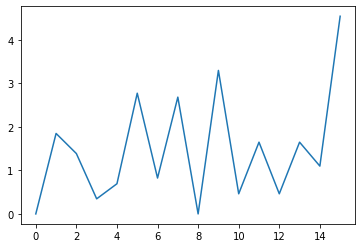

In [45]:
plt.plot(transplant_arr[0, :, -2])

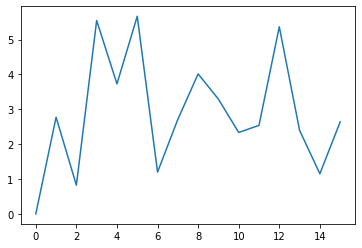

In [46]:
plt.plot(transplant_arr[2638, :, -2])

In [47]:
transplant_name[2638]

(2638, 'remote ischemic conditioning')

In [22]:
sum(transplant_arr[0, :, 0])

35.0

In [48]:
yt, yp = eval_model('classification', np.expand_dims(y_test, axis=1), np.expand_dims(y_pred, axis=1), None)

In [50]:
from sklearn.metrics import classification_report

In [51]:
print(classification_report(yt, yp))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2686
           1       0.13      0.40      0.20       865
           2       0.19      0.22      0.20       663
           3       0.29      0.22      0.25       664
           4       0.08      0.39      0.14       263

    accuracy                           0.14      5141
   macro avg       0.14      0.24      0.16      5141
weighted avg       0.09      0.14      0.10      5141



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [52]:
eval_model('ndcg', np.expand_dims(y_test, axis=1), np.expand_dims(y_pred, axis=1), None)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


(0.8213689751359761, [0.8213689751359761])